## ロジスティック回帰
Irisデータセットを使用して、ロジスティック回帰のアルゴリズムを構築

### ロジスティック回帰とは
ロジスティック回帰とは、分類のアルゴリズムの１つであり、基本的には目的変数が２値のときに利用する。値域が[0,1]で総和が1になるようなxの線形関数を用いてK個のクラス事後確率をモデル化したいという欲求から生まれたモデルである。



### データセットの用意

In [1]:
import numpy as np  # 線形代数ライブラリー
import pandas as pd  # データの加工, CSVファイルの読み書き
import matplotlib.pyplot as plt  # 描画ライブラリー

import seaborn as sns  # 描画スタイル変更ライブラリ
%matplotlib inline
from sklearn.model_selection import train_test_split

iris_df = pd.read_csv('/Users/andoutakaaki/DIC_study/Sprint3/Iris.csv')  # csvファイルの読み込み
iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


### ２値分類
今回は以下の2つのクラスを分類

Iris-versicolor
Iris-virginica

In [2]:
# 2クラスに絞る
iris_df = iris_df[iris_df["Species"] != "Iris-setosa"]

y_df = iris_df[["Species"]]
x_df = iris_df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]

In [3]:
# numpyでSpecies（種類）を数値（0,1）に変換
class_mapping = {label:idx for idx,label in enumerate(np.unique(y_df["Species"]))} 
y_df["Species"]=y_df["Species"].map(class_mapping)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
X_train, X_test, y_train, y_test=train_test_split(x_df,y_df, train_size=0.8,test_size=0.2,stratify=y_df.Species)

In [5]:
X_train.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
143,6.8,3.2,5.9,2.3
130,7.4,2.8,6.1,1.9
86,6.7,3.1,4.7,1.5
91,6.1,3.0,4.6,1.4
112,6.8,3.0,5.5,2.1


### EDA

In [6]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 50 to 149
Data columns (total 6 columns):
Id               100 non-null int64
SepalLengthCm    100 non-null float64
SepalWidthCm     100 non-null float64
PetalLengthCm    100 non-null float64
PetalWidthCm     100 non-null float64
Species          100 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 5.5+ KB


IDを除いて４つの特徴があり、各々がく片（Sepal）と花びら（Petal）の長さ（Length）と幅（Width）で、
種類は、Iris-versicolorとIris-virginica。欠損値はない

### 可視化

2種類のがく片（Sepal）の長さ（Length）と幅（Width）の描写

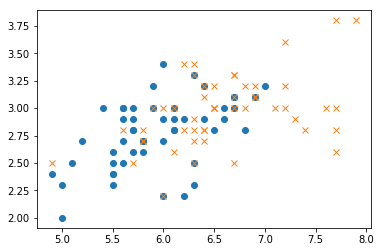

In [7]:
iris_versicolor = iris_df[iris_df['Species'] == 'Iris-versicolor']
iris_virginica  = iris_df[iris_df['Species']=='Iris-virginica']

plt.plot(iris_versicolor["SepalLengthCm"], iris_versicolor['SepalWidthCm'], 'o')
plt.plot(iris_virginica["SepalLengthCm"], iris_virginica['SepalWidthCm'], 'x')

２種類の花びら（Petal）の長さ（Length）と幅（Width）の描写

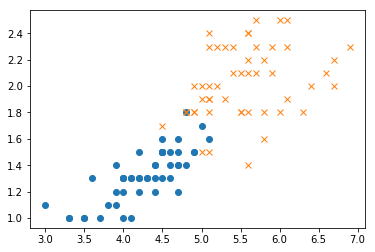

In [8]:
plt.plot(iris_versicolor['PetalLengthCm'], iris_versicolor['PetalWidthCm'], 'o')
plt.plot(iris_virginica['PetalLengthCm'], iris_virginica['PetalWidthCm'], 'x')

どちらも、長さと幅なので正の相関を表すが、がく片よりも花びらの方が相関している

### シグモイド関数を描画

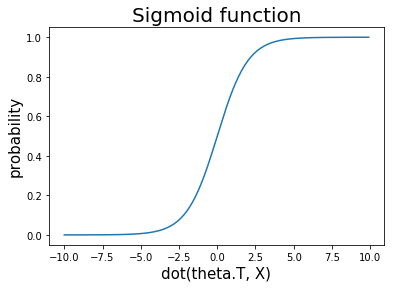

In [9]:
# シグモイド関数を描画する
import math

x = np.arange(-10, 10, 0.1)
e = math.e

y = 1 / (1 + e**-x)

plt.plot(x, y)
plt.xlabel("dot(theta.T, X)", fontsize= 15)
plt.ylabel("probability", fontsize= 15)
plt.title("Sigmoid function", fontsize=20)
plt.show()

### シグモイド関数の実装

In [10]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

sigmoid(0.5)

0.6224593312018546

### シグモイド関数
ロジスティック回帰では予測する出力が数値ではなくカテゴリーに属するかどうかの確率になる。 そのため下記３つの条件をみたすシグモイド関数がよく用いられる。

$h_\theta(x)$がどんな値を取ったときも0から1の値を取ることができる。
単調増加のため値の大小関係は崩れない。
$h_\theta(x)$の正負で分類が可能であり、判定が楽。

### 正則化とは
あるパラメータ$\theta_j$が大きな値をとってしまうと収束できなかったり、収束が遅くなってしまう。 そのため$\theta$が大きいものはコストが大きくなるようにペナルティを与えて、 $\theta$が大きい値を取らないように補正することを正則化と呼ぶ。

正則化によって各特徴量の係数に当たるパラメータ $\theta$ の値を小さくして、そのパラメータの特徴量の影響を 軽減させることで、目的関数$J\theta$の値を収束させる。

### ロジスティック回帰における、目的関数(コスト関数)
ロジスティック回帰における、目的関数(コスト関数)を実装すること。
数式は以下になる。（この数式には、正則項が含まれていることに注意。）

$h_θ(x) = g(θ^T x).$

$g(z) = \frac{1}{1+e^{−z}}.$


In [11]:
# 切片を追加する
x_df.insert(0, "x0", 1)

# thetaを設定する
theta = pd.DataFrame([0.1,0.2,0.3,0.4,0.5])

x_df.head()

,x0,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
50,1,7.0,3.2,4.7,1.4
51,1,6.4,3.2,4.5,1.5
52,1,6.9,3.1,4.9,1.5
53,1,5.5,2.3,4.0,1.3
54,1,6.5,2.8,4.6,1.5


### 二乗誤差と交差エントロピー誤差

なぜロジスティック回帰では二乗誤差ではなく交差エントロピー誤差関数を目的関数とするのか。

回帰問題の目的は予測した誤差を最小にするのが目的であるのに対し、 分類問題の目的はそれぞれのデータがあるクラスと予測する確率を出し、すべてのデータで予測した分類が正解する、つまりそれぞれの事象の同時確率が最大になることが目的となるため。

各データの同時確率（積集合）が目的関数になる。 これだとそれぞれ0~1の値を取るためデータ数が増えるとアンダーフローになり正しく判定できなくなる。 これを防ぐために対数をとった式が今回採用する交差誤差エントロピー誤差関数となる。 (合わせてフィーチャースケーリングもできるというメリットもある。）

### 目的関数の実装

In [12]:
def compute_cost(X, y, theta, lam):
    z=np.dot(X,theta)
    sig=sigmoid(z)
    m=len(X)
    correct_or_not = np.ones(theta.count())
    correct_or_not[0] = 0
    # シグモイド関数、ラムダ、目的変数を目的関数に組み込む
    return ((-1*y*np.log(sig)-(1-y)*np.log(1-sig)).sum()/m)[0]+(lam/(2*m))*((theta**2)* correct_or_not[:, np.newaxis]).sum()[0]

compute_cost(x_df, y_df, theta, 0.01)

2.2509192579971002

### 最急降下法

最急降下法を実装すること。また、内部からコスト関数を呼び出し、アルゴリズムを完成させること。
数式は以下になる。

$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0$

$\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1$

In [13]:
import pandas as pd

In [14]:
def gradient_descent(X, y, theta, iterations, alpha, lam):
    """
    args:
      alpha: Step size/Learning rate
      iterations: No. of iterations(Number of iterations)
    """
    past_costs = []
    past_thetas = [theta]
    
    correct_or_not = pd.DataFrame(np.ones(theta.count()))
    correct_or_not[0][0]= 0
    
    m=len(X)
    
    for a in range(iterations):
        reg_term = lam * theta * correct_or_not
        z=np.dot(X,theta)
        sig=sigmoid(z)
        theta = theta - alpha/m*(np.dot(X.T, (sig-y)) + reg_term)
        past_costs.append(compute_cost(X, y, theta, lam))
        past_thetas.append(theta)

    
    return past_costs,past_thetas

theta = pd.DataFrame([0.9,0.8,0.6,0.9,0.6])
(past_costs,past_thetas)=gradient_descent(x_df, y_df, theta, iterations=200, alpha=0.01, lam=0.01)
past_costs

[5.810770454649666,
 5.651227946256371,
 5.49168761908524,
 5.3321501388582275,
 5.172616412516046,
 5.013087677058401,
 4.853565621636149,
 4.694052555529916,
 4.534551639521547,
 4.375067204927222,
 4.2156051939325865,
 4.056173767900891,
 3.896784148357801,
 3.737451780277683,
 3.5781979416036815,
 3.419051969842399,
 3.260054340123075,
 3.1012609139452474,
 2.942748788577604,
 2.784624316542013,
 2.627034029949297,
 2.470179379063005,
 2.3143363328509516,
 2.159880890244535,
 2.0073212151513617,
 1.8573360833853318,
 1.7108170675738361,
 1.5689077008109649,
 1.4330262818624475,
 1.304850719522101,
 1.1862374447656,
 1.0790499287834543,
 0.984896192716389,
 0.9048219843832017,
 0.8390575590868171,
 0.7869283295905991,
 0.7469817878986111,
 0.7172817791322169,
 0.695750341130467,
 0.6804440630790878,
 0.6697131239606122,
 0.6622517708587817,
 0.6570778482842431,
 0.6534792705855954,
 0.6509532145121076,
 0.6491512704002858,
 0.647835263818795,
 0.6468439466989072,
 0.646068909324482,

### 学習曲線の描写

In [15]:
def plot_learning_curve(X, y, theta, iterations, alpha, lam):
    # データを用意
    past_costs, past_thetas = gradient_descent(X, y, theta, iterations, alpha, lam)
    
    plt.figure(figsize=(12, 8))
    plt.plot(range(iterations), past_costs, label='Iris-setosa')
    # 凡例
    plt.legend()

    # 座標系の名前
    plt.title('Cost Fusion J')
    # x軸の名前
    plt.xlabel("Iterations")
    # y軸の名前
    plt.ylabel("Cost")

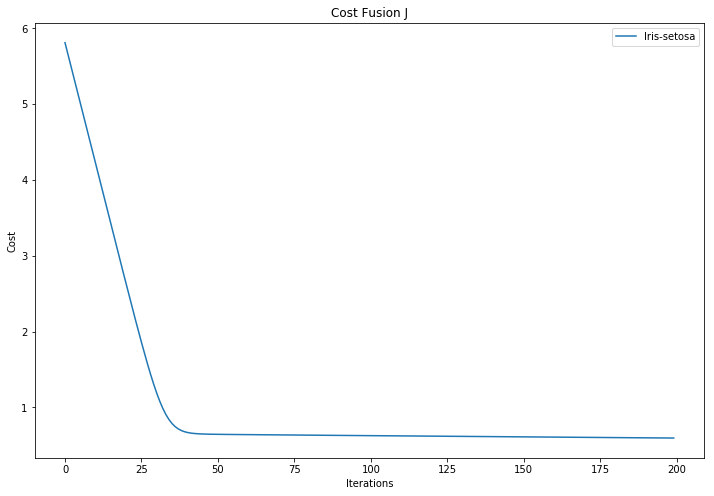

In [16]:
plot_learning_curve(x_df, y_df, theta, iterations=200, alpha=0.01, lam=0.01)

### 予測関数
学習済みの分類器を使用して、実際に予測を行う関数を作成

In [17]:
def predict_probs(X, theta):
    z=np.dot(X,theta)
    sig=sigmoid(z)
    return sig

In [18]:
predict_probs(x_df, past_thetas[-1])

array([[0.40828362],
       [0.47008586],
       [0.44566665],
       [0.51031983],
       [0.46847972],
       [0.52226293],
       [0.50728339],
       [0.48640808],
       [0.43244889],
       [0.54591748],
       [0.49198499],
       [0.50331634],
       [0.41993865],
       [0.50565333],
       [0.4678755 ],
       [0.41918002],
       [0.55695821],
       [0.44573379],
       [0.49651221],
       [0.46628432],
       [0.58243562],
       [0.44347502],
       [0.51302914],
       [0.48101353],
       [0.43241725],
       [0.43018743],
       [0.43825298],
       [0.49981917],
       [0.51460793],
       [0.41448077],
       [0.47033962],
       [0.4507031 ],
       [0.45638777],
       [0.57083744],
       [0.57810493],
       [0.52470304],
       [0.45275222],
       [0.45305451],
       [0.50329823],
       [0.50933643],
       [0.52502136],
       [0.49796989],
       [0.46402263],
       [0.47614317],
       [0.51196346],
       [0.48715079],
       [0.50021038],
       [0.453

In [19]:
species=[]
species.append('Iris-virginica')
species

['Iris-virginica']

In [20]:
# 分類を行う。
def predict(X, theta, threshold=0.5):
    probs=predict_probs(X, theta)
    species=[]
    
    for i in range(len(X)):
        if probs[i,-1]>=0.5:
            species.append('Iris-virginica')
        else:
            species.append('Iris-versicolor')
        
    return species

In [21]:
pred= predict(x_df,past_thetas[-1])

In [22]:
real=iris_df[["Species"]]
print(str(real.iloc[0][0]))

Iris-versicolor


In [23]:
# 正解率
count = 0
for i in range(len(pred)):

#     print(pred[i])
#     print(real.iloc[i][0])
    if pred[i] == real.iloc[i][0]:
        count += 1
print(count/100)

0.81


今回のモデルの正答率８１％

### クラス化

In [24]:
class LogisticRegression():

    def __init__(self, theta):
        self.theta = theta     # ハイパーパラメータを属性として記録
        
    def compute_cost(self, X, y, lam):
        z=np.dot(X, self.theta)
        sig=sigmoid(z)
        m=len(X)
        # シグモイド関数、ラムダ、目的変数を目的関数に組み込む
        return ((-1*y*np.log(sig)-(1-y)*np.log(1-sig)).sum()/m)[0]+(lam/(2*m))*((self.theta**2)** pd.DataFrame([0,1,1,1,1])).sum()[0]

    def gradient_descent(self, X, y, iterations, alpha, lam, reset_theta=False):
        """
        args:
          alpha: Step size/Learning rate
          iterations: No. of iterations(Number of iterations)
        """
        if reset_theta:
            self.theta = pd.DataFrame(np.random.rand(5))
        
        past_costs = []
        past_thetas = [self.theta]
        correct_or_not = pd.DataFrame(np.ones(self.theta.count()))
        correct_or_not[0][0]= 0

        m=len(X)

        for a in range(iterations):
            reg_term = lam * theta * correct_or_not
            z=np.dot(X, self.theta)
            sig=sigmoid(z)
            self.theta = self.theta - alpha/m*(np.dot(X.T, (sig-y)) + reg_term)
            past_costs.append(self.compute_cost(X, y, lam))
            past_thetas.append(self.theta)

        return past_costs,past_thetas

    def plot_learning_curve(self, X, y, iterations, alpha, lam, reset_theta=False):
        if reset_theta:
            self.theta = pd.DataFrame(np.random.rand(5))

        past_costs, past_thetas = self.gradient_descent(X, y, iterations, alpha, lam)

        plt.figure(figsize=(12, 8))
        plt.plot(range(iterations), past_costs, label='Iris-setosa')

        plt.legend()
        plt.title('Cost Fusion J')
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        
    def predict_probs(self, X):
        z=np.dot(X, self.theta)
        return sigmoid(z)

    def predict(self, X):
        probs=self.predict_probs(X)
        species=[]
        for i in range(len(X)):
            if probs[i,-1]>=0.5:
                species.append(1)
            else:
                species.append(0)
        return species

In [25]:
theta = pd.DataFrame([0.1,0.2,0.3,0.4,0.5])
model = LogisticRegression(theta)

In [26]:
model.compute_cost(x_df, y_df, 0.01)

2.2509692579971

In [27]:
(past_costs,past_thetas)=model.gradient_descent(x_df, y_df, 1000, 0.05, 0.01, True)
past_thetas[-1]

,0
0,-0.202929
1,-1.920887
2,-1.553781
3,2.457424
4,2.828328


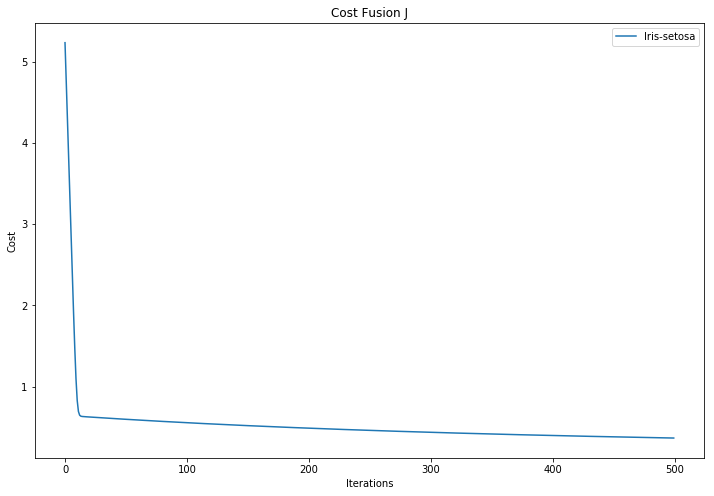

In [28]:
model.plot_learning_curve(x_df, y_df, 500, 0.03, 0.01, True)

In [29]:
model.predict(x_df)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [30]:
pred= predict(x_df,past_thetas[-1])

# 正解率
count = 0
for i in range(len(pred)):

#     print(pred[i])
#     print(real.iloc[i][0])
    if pred[i] == real.iloc[i][0]:
        count += 1
print(count/100)

0.96


### テスト
上記で作成した、関数のテストを作成せよ。尚このテストには、sklearnにおける、LinearRegressionのテストを参考にする
以下のテストを最低限作成する

sigmoid function
コスト関数
最急降下法
predict関数

計算サイトで確認
https://keisan.casio.jp/exec/system/1515561226

下記の値になるか確認

・0.5のとき0.6224593312018545646389
・0のとき0.5
・-0.7のとき0.3318122278318338934692

In [31]:
print(sigmoid(0.5))
print(sigmoid(0))
print(sigmoid(-0.7))

0.6224593312018546
0.5
0.3318122278318339


想定通りの結果となったことを確認

### コスト関数のテスト

In [32]:
X = pd.DataFrame([[-1],  [-1]])
# 切片
X["x0"] = 1
X=X.iloc[:,[1, 0]]
X
theta = pd.DataFrame([1, 1])
y = pd.DataFrame([1, 0])
# (-log(1/2) -log(1/2) )/2 = 
# In [10]: -math.log(1/2)
# Out[10]: 0.6931471805599453
# 正則項なし 
print("compute_cost is {}".format(compute_cost(X, y, theta, 0)))

# (-log(1/2) -log(1/2) )/2 + 1/2*2 (1 ^2) =  
# In [13]: -math.log(1/2) + 1/4
# Out[13]: 0.9431471805599453
# 正則項あり
print("compute_cost is {}".format(compute_cost(X, y, theta, 1)))

compute_cost is 0.6931471805599453
compute_cost is 0.9431471805599453


ipython で確認した値と同値であることを確認

### 最急降下法　predict関数のテスト

データを用意。 
x1軸,x2軸の値が1,-1の点を４点用意して、
正の値を取るものを1,負の値を取るものを0に分類。

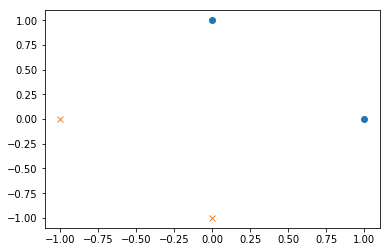

,x0,0,1
0,1,1,0
1,1,0,1
2,1,-1,0
3,1,0,-1


In [33]:
X = pd.DataFrame([[1,0], [0,1], [-1,0], [0,-1]])
plt.plot(X[0][0:2], X[1][0:2], 'o')
plt.plot(X[0][2:], X[1][2:], 'x')
plt.show()
# 切片
X["x0"] = 1
X=X.iloc[:,[2, 0,1]]
X


In [34]:
y = pd.DataFrame([1, 1, 0, 0])
y

,0
0,1
1,1
2,0
3,0


In [35]:
theta = pd.DataFrame([0.1,0.2,0.3])

#print("compute_cost is {}".format(compute_cost(X, y, theta, 1)))

past_cost, past_thetas = gradient_descent(X, y, theta, 500, 0.01, 0.01)

In [36]:
past_cost[-1]

0.29650414611581694

In [37]:
past_thetas[-1]

,0
0,0.033340
1,1.047306
2,1.104357


最急降下法で収束した$\theta$が[0, 1, 1]付近になっていることを確認

In [38]:
def predict_probs_test(X, theta):
    z=np.dot(X,theta)
    sig=sigmoid(z)
    return sig

# 分類を行う。
def predict_test(X, theta, threshold=0.5):
    probs=predict_probs_test(X, past_thetas[-1])
    species=[]
    
    for i in range(len(X)):
        if probs[i,-1]>=0.5:
            species.append(1)
        else:
            species.append(0)
        
    return species
pred_val = predict_test(X, past_thetas[-1])

In [39]:
print(pred_val)

print(y.T.values)

[1, 1, 0, 0]
[[1 1 0 0]]


予測関数を通した分類が想定した値になっていることを確認